<a href="https://colab.research.google.com/github/1900690/Water-meter-reading/blob/main/water_meter_reading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#クラス分類系データセットをfastlabel->ultralitics hub 変換用コード

In [ ]:
file_name ="anarog-meter-reading-analog-meter_20260123140448.zip"

#データを解凍
shutil.unpack_archive('/content/'+file_name, '/content/')
os.rename('/content/'+os.path.splitext(file_name)[0]+'/', '/content/foward/')
#zipを消す
os.remove('/content/'+file_name)

In [ ]:
# @title 📊 データ整理とフォルダ別オーグメンテーションの設定 { run: "auto" }
import os
import pandas as pd
import shutil
import cv2
import numpy as np
import albumentations as A
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# --- 基本設定 ---
# @markdown ### 📁 パスと分割の設定
csv_path = '/content/csv/annotations.csv' # @param {type:"string"}
source_img_dir = '/content/original' # @param {type:"string"}
output_root_dir = '/content/dataset/classify' # @param {type:"string"}

# @markdown ---
# @markdown ### 📈 分割比率の指定
train_ratio = 0.7 # @param {type:"slider", min:0, max:1, step:0.1}
val_ratio = 0.2 # @param {type:"slider", min:0, max:1, step:0.1}
test_ratio = 0.1 # @param {type:"slider", min:0, max:1, step:0.1}

#あったら消す
shutil.rmtree(output_root_dir, ignore_errors=True)

# --- オーグメンテーション設定 ---
# @markdown ---
# @markdown ### ✨ オーグメンテーションを適用するフォルダの選択
# @markdown どのフォルダを水増しするか個別に指定してください。
apply_to_train = True # @param {type:"boolean"}
apply_to_val = True # @param {type:"boolean"}
apply_to_test = False # @param {type:"boolean"}

# @markdown **1枚の元画像から追加生成する枚数**
num_augmented_per_image = 10 # @param {type:"integer"}

# @markdown ---
# @markdown ### 🛠️ 加工メニューの選択と解説
# @markdown #### 【幾何学的変化】
# @markdown - **Rotation (回転)**: カメラの傾きや、被写体が斜めになっている状況を再現
use_rotation = True # @param {type:"boolean"}
# @markdown - **Translation (移動)**: 被写体が中心からズレる状況を再現
use_translation = True # @param {type:"boolean"}

# @markdown #### 【光と色の変化】
# @markdown - **Brightness/Contrast**: 晴天、曇天、室内灯、逆光など照明環境を再現
use_color_jitter = True # @param {type:"boolean"}
# @markdown - **Hue Shift**: センサーによる色味の違いや製品の個体差を再現
use_hue_shift = True # @param {type:"boolean"}

# @markdown #### 【画質劣化の再現】
# @markdown - **Gaussian Noise**: 暗所撮影時のザラつきやノイズを再現
use_noise = True # @param {type:"boolean"}
# @markdown - **Blur (ぼかし)**: 手ブレやピントの甘さを再現
use_blur = True # @param {type:"boolean"}

def get_augmentation_pipeline():
    transforms = []
    if use_rotation: transforms.append(A.Rotate(limit=30, p=0.5))
    if use_translation: transforms.append(A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=0, p=0.5))
    if use_color_jitter: transforms.append(A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5))
    if use_hue_shift: transforms.append(A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5))
    if use_noise: transforms.append(A.GaussNoise(var_limit=(10.0, 50.0), p=0.3))
    if use_blur: transforms.append(A.Blur(blur_limit=3, p=0.3))
    return A.Compose(transforms)

def process_dataset():
    if round(train_ratio + val_ratio + test_ratio, 10) != 1.0:
        print("⚠️ 警告: 比率の合計を1.0にしてください。")
        return

    aug_pipeline = get_augmentation_pipeline()
    df = pd.read_csv(csv_path)
    labels = df['Attribute Value'].unique()

    # フォルダ作成
    for split in ['train', 'val', 'test']:
        for label in labels:
            os.makedirs(os.path.join(output_root_dir, split, str(label)), exist_ok=True)

    all_data_plans = []
    summary_data = []

    # 設定マップ
    aug_settings = {
        'train': apply_to_train,
        'val': apply_to_val,
        'test': apply_to_test
    }

    print("--- 1. 元データの分割統計 (Original) ---")
    for label in labels:
        class_df = df[df['Attribute Value'] == label]
        filenames = class_df['Name'].tolist()

        train_files, temp_files = train_test_split(filenames, test_size=(1 - train_ratio), random_state=42)
        rel_val_ratio = val_ratio / (val_ratio + test_ratio) if (val_ratio + test_ratio) > 0 else 0
        val_files, test_files = train_test_split(temp_files, test_size=(1 - rel_val_ratio), random_state=42) if len(temp_files) > 1 else (temp_files, [])

        print(f"Class {label}: Train={len(train_files)}, Val={len(val_files)}, Test={len(test_files)}")

        counts = {'train': 0, 'val': 0, 'test': 0}
        for split, files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
            for f in files:
                # オリジナル画像
                all_data_plans.append({'split': split, 'label': label, 'filename': f, 'is_aug': False})
                counts[split] += 1
                # フォルダごとの設定に応じてオーグメンテーション
                if aug_settings[split]:
                    for i in range(num_augmented_per_image):
                        all_data_plans.append({'split': split, 'label': label, 'filename': f, 'is_aug': True, 'aug_index': i})
                        counts[split] += 1

        summary_data.append({'label': label, 'counts': counts})

    print("\n--- 2. オーグメンテーション後の最終統計 (Final Expected) ---")
    for item in summary_data:
        c = item['counts']
        print(f"Class {item['label']}: Train={c['train']}, Val={c['val']}, Test={c['test']} (合計: {sum(c.values())}枚)")

    print(f"\n🚀 処理を開始します (総処理数: {len(all_data_plans)})")
    success, errors = 0, 0

    for plan in tqdm(all_data_plans, desc="整理・加工進捗"):
        src_path = os.path.join(source_img_dir, plan['filename'])
        if not os.path.exists(src_path):
            errors += 1
            continue

        ext = os.path.splitext(plan['filename'])[1]
        dst_name = f"{os.path.splitext(plan['filename'])[0]}_aug_{plan['aug_index']}{ext}" if plan['is_aug'] else plan['filename']
        dst_path = os.path.join(output_root_dir, plan['split'], str(plan['label']), dst_name)

        if plan['is_aug']:
            image = cv2.imread(src_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                augmented = aug_pipeline(image=image)['image']
                augmented = cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR)
                cv2.imwrite(dst_path, augmented)
                success += 1
            else: errors += 1
        else:
            shutil.copy2(src_path, dst_path)
            success += 1

    print(f"\n完了！ 全ての画像は {output_root_dir} に整理されました。")
    print(f"✅ 成功: {success} 枚 / ❌ 失敗: {errors} 枚")

# 実行
process_dataset()

In [ ]:
import shutil
import os

shutil.make_archive('/content/dataset', 'zip', '/content/dataset')

#動画を指定座標に合わせてトリミング

In [1]:
!pip install moviepy

In [8]:
!pip uninstall -y opencv-python opencv-contrib-python
!pip install opencv-contrib-python

Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-python-4.12.0.88
Found existing installation: opencv-contrib-python 4.12.0.88
Uninstalling opencv-contrib-python-4.12.0.88:
  Successfully uninstalled opencv-contrib-python-4.12.0.88
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 MB 6.9 MB/s eta 0:00:00


In [ ]:
#@title 1. 動画の確認とグリッド表示
import cv2
import os
from moviepy.editor import VideoFileClip
from google.colab.patches import cv2_imshow

# --- 設定項目 ---
video_path = "/content/PXL_20260123_025224014.mp4" #@param {type:"string"}
start_sec = 0 #@param {type:"number"}
end_sec = 30 #@param {type:"number"}

trimmed_path = "trimmed_temp.mp4"

if os.path.exists(video_path):
    print("動画を読み込んでいます...")
    with VideoFileClip(video_path) as clip:
        # 指定時間でカット
        duration = clip.duration
        safe_end = min(end_sec, duration)
        trimmed_clip = clip.subclip(start_sec, safe_end)
        trimmed_clip.write_videofile(trimmed_path, codec="libx264", audio=False, verbose=False, logger=None)

    # 最初の手振れ補正前のフレームを取得
    cap = cv2.VideoCapture(trimmed_path)
    success, frame = cap.read()
    if success:
        h, w = frame.shape[:2]
        grid_frame = frame.copy()
        # グリッド描画
        for x in range(0, w, 100):
            cv2.line(grid_frame, (x, 0), (x, h), (255, 255, 255), 1)
            cv2.putText(grid_frame, str(x), (x, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        for y in range(0, h, 100):
            cv2.line(grid_frame, (0, y), (w, y), (255, 255, 255), 1)
            cv2.putText(grid_frame, str(y), (5, y + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        print(f"解像度: {w}x{h}")
        cv2_imshow(grid_frame)
        print("上の画像を見て、次のステップで入力する座標(x, y, width, height)を決めてください。")
    cap.release()
else:
    print("指定されたパスにファイルが見つかりません。")

In [ ]:
#@title 2. 補正の実行
import numpy as np
import cv2
import os
from moviepy.editor import VideoFileClip
from google.colab.patches import cv2_imshow
#@markdown ステップ1で確認したメータの範囲を入力してください
roi_x = 1500 #@param {type:"integer"}
roi_y = 400 #@param {type:"integer"}
roi_w = 2100 #@param {type:"integer"}
roi_h = 1500 #@param {type:"integer"}
output_filename = "stabilized_video.mp4" #@param {type:"string"}

trimmed_path = "trimmed_temp.mp4"
roi = (roi_x, roi_y, roi_w, roi_h)

cap = cv2.VideoCapture(trimmed_path)
success, first_frame = cap.read()

if not success:
    print("動画の読み込みに失敗しました。ステップ1を先に実行してください。")
else:
    h, w = first_frame.shape[:2]
    # トラッカー初期化 (CSRT)
    # アンダースコアをドットに変更します
    tracker = cv2.legacy.TrackerCSRT_create()
    tracker.init(first_frame, roi)

    # 保存設定
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)
    out = cv2.VideoWriter(output_filename, fourcc, fps, (w, h))

    # 基準座標（中心）
    origin_center = (roi_x + roi_w/2, roi_y + roi_h/2)

    print("補正処理中...")
    while True:
        success, frame = cap.read()
        if not success: break

        success_track, box = tracker.update(frame)
        if success_track:
            curr_x, curr_y, curr_w, curr_h = [int(v) for v in box]
            curr_center = (curr_x + curr_w/2, curr_y + curr_h/2)

            # ズレを計算して補正
            dx = origin_center[0] - curr_center[0]
            dy = origin_center[1] - curr_center[1]
            matrix = np.float32([[1, 0, dx], [0, 1, dy]])
            stabilized_frame = cv2.warpAffine(frame, matrix, (w, h))
            out.write(stabilized_frame)
        else:
            out.write(frame)

    cap.release()
    out.release()
    print(f"完了！ ファイルを保存しました: {output_filename}")

補正処理中...


#動画から必要部分を切り出して、0~9までのアノテーションをして、fastlabelのjson形式に修正する

#魚眼補正済みの動画から赤色の数字の部分の動画のみを取り出す。

In [ ]:
import cv2
import numpy as np
import os
import requests
from tqdm import tqdm
from google.colab import files
from google.colab.patches import cv2_imshow

# --- 設定エリア ---
# URLを直接指定
REF_URL_1 = "https://github.com/1900690/Water-meter-reading/releases/download/ref/ref_mark1.jpg"
REF_URL_2 = "https://github.com/1900690/Water-meter-reading/releases/download/ref/ref_mark2.jpg"
VIDEO_URL = "https://github.com/1900690/Water-meter-reading/releases/download/movie/seg0_6_ajusted.mp4"

TARGET_REF1_POS = (640, 130)
TARGET_REF2_POS = (550, 510)
TARGET_W, TARGET_H = 1280, 720
ROI_RED_DIGIT = (703, 190, 55, 90) # (x, y, w, h)

# --- ユーティリティ関数 ---

def download_file(url, save_name):
    """URLからファイルをダウンロードする"""
    print(f"ダウンロード中: {url}")
    r = requests.get(url)
    if r.status_code == 200:
        with open(save_name, 'wb') as f:
            f.write(r.content)
        return save_name
    else:
        print(f"ダウンロード失敗: {url}")
        return None

def rotate_image(image, angle):
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

def align_image_colab(img, templ1, templ2):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    best_score = -1
    best_angle = 0
    for angle in range(-15, 16, 5):
        rotated = rotate_image(gray, angle)
        res = cv2.matchTemplate(rotated, templ1, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, _ = cv2.minMaxLoc(res)
        if max_val > best_score:
            best_score = max_val
            best_angle = angle

    rotated_img = rotate_image(img, best_angle)
    r_gray = cv2.cvtColor(rotated_img, cv2.COLOR_BGR2GRAY)
    _, _, _, p1 = cv2.minMaxLoc(cv2.matchTemplate(r_gray, templ1, cv2.TM_CCOEFF_NORMED))
    _, _, _, p2 = cv2.minMaxLoc(cv2.matchTemplate(r_gray, templ2, cv2.TM_CCOEFF_NORMED))

    src_pts = np.float32([p1, p2])
    dst_pts = np.float32([TARGET_REF1_POS, TARGET_REF2_POS])
    M_fine, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts)

    if M_fine is None:
        return cv2.resize(rotated_img, (TARGET_W, TARGET_H))
    return cv2.warpAffine(rotated_img, M_fine, (TARGET_W, TARGET_H), borderValue=(255,255,255))

# --- メイン処理 ---

def run_process():
    # 1. 基準画像のダウンロードと読み込み
    ref1_path = download_file(REF_URL_1, "ref1.jpg")
    ref2_path = download_file(REF_URL_2, "ref2.jpg")

    templ1 = cv2.imread(ref1_path, 0)
    templ2 = cv2.imread(ref2_path, 0)

    if templ1 is None or templ2 is None:
        print("エラー: 基準画像の読み込みに失敗しました。")
        return

    # 2. 動画のダウンロード
    video_path = download_file(VIDEO_URL, "input_video.mp4")
    if video_path is None: return

    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    x, y, w, h = ROI_RED_DIGIT
    output_filename = "red_digit_output.mp4"
    # コーデックを 'avc1' (H.264) にするとブラウザで再生しやすくなります
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (w, h))

    # 3. プレビュー表示
    ret, first_frame = cap.read()
    if ret:
        aligned_sample = align_image_colab(first_frame, templ1, templ2)
        preview_img = aligned_sample.copy()
        cv2.rectangle(preview_img, (x, y), (x+w, y+h), (0, 0, 255), 3)
        print("\n【確認】以下の赤枠部分（赤色数字）を切り出します：")
        cv2_imshow(cv2.resize(preview_img, (800, 450)))

    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

    # 4. 全フレーム処理
    print(f"\n解析開始: {total_frames} フレームを処理中...")
    for _ in tqdm(range(total_frames)):
        ret, frame = cap.read()
        if not ret: break
        aligned = align_image_colab(frame, templ1, templ2)
        crop = aligned[y:y+h, x:x+w]
        out.write(crop)

    cap.release()
    out.release()
    print(f"\n完了！ ファイル名: {output_filename}")

    # 5. ダウンロード
    #files.download(output_filename)

if __name__ == "__main__":
    run_process()

#動画を画像に分割

In [ ]:
import shutil
import cv2
import os

#この動画が画像取り出しされる
LOAD_VIDEO_PATH = '/content/red_digit_output.mp4'  # 修正: 処理する単一の動画ファイルのパスを指定

if os.path.exists("/content/slice"):
  shutil.rmtree("/content/slice")

def save_frame_range(video_path,
                     dir_path, ext='jpg'):

    basename=os.path.splitext(os.path.basename(video_path))[0] # ファイル名から拡張子を除いた部分をbasenameとして使用
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}. It might be missing, corrupted, or an unsupported format.")
        return

    # 動画のプロパティを取得
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT));

    # 真ん中+1のフレームを取り出すプラスの数値を調整することでフレームをずらせる
    # 現在の設定では全フレームを取り出す
    start_frame=0
    stop_frame=total_frames
    step_frame=1

    os.makedirs(dir_path, exist_ok=True)
    base_path = os.path.join(dir_path, basename)

    # ファイル名の桁数を計算
    digit = len(str(total_frames))

    for n in range(start_frame, stop_frame, step_frame):
        cap.set(cv2.CAP_PROP_POS_FRAMES, n)
        ret, frame = cap.read()
        if ret:
            cv2.imwrite('{}_{}.{}'.format(base_path, str(n).zfill(digit), ext), frame)
        else:
            # フレームが読み込めない場合はループを終了
            print(f"Warning: Could not read frame {n} from {video_path}. Stopping processing for this video.")
            break

    cap.release() # VideoCaptureオブジェクトを解放
    print(f"Finished processing {video_path}")


#スライスフォルダを作成
SAVE_NAME = 'slice'
if not os.path.exists('/content/' +SAVE_NAME):
    os.mkdir('/content/' +SAVE_NAME)

# 単一の動画ファイルを処理
video_file_name = os.path.basename(LOAD_VIDEO_PATH)
save_dir_for_video = os.path.join('/content/', SAVE_NAME, os.path.splitext(video_file_name)[0])
os.makedirs(save_dir_for_video, exist_ok=True)
save_frame_range(LOAD_VIDEO_PATH, save_dir_for_video)

#圧縮してダウンロード

In [ ]:
import shutil

# Compress the entire '/content/slice' directory into a zip archive
shutil.make_archive(base_name='sliced_images', format='zip', root_dir='/content', base_dir='slice')

#赤色の数字の部分の画像からfastlabel用のインポートアノテーションを作成する

In [ ]:
!pip install easyocr

解析したい画像が入ったZIPファイルをアップロードしてください。


Saving meter.zip to meter (2).zip
653 枚の画像を処理中...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument i

分析完了！ 結果を annotations_result.json に保存しました。


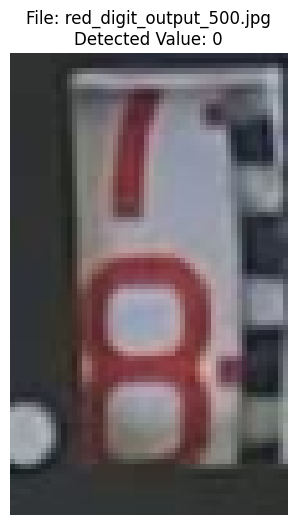

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import zipfile
import json
import random
import cv2
import easyocr
import numpy as np
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import uuid
from datetime import datetime

# 1. ZIPファイルのアップロード
print("解析したい画像が入ったZIPファイルをアップロードしてください。")
uploaded = files.upload()
zip_name = list(uploaded.keys())[0]

# 解凍先のディレクトリ作成
input_dir = 'meter_images'
os.makedirs(input_dir, exist_ok=True)

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(input_dir)

# 2. OCRモデルの初期化 (数字のみをターゲットに設定)
reader = easyocr.Reader(['en'])

def analyze_meter(image_path):
    """
    画像から0-9の1桁のみを読み取る関数
    """
    # OCR実行 (数字のみ、かつ1文字に絞るためのヒント設定)
    # allowlistで0-9以外の読み取りを禁止
    results = reader.readtext(image_path, allowlist='0123456789')

    if len(results) > 0:
        # 1. 複数の候補がある場合、信頼度(score)が最も高いものを選択
        # resultsは [(bbox, text, score), ...] の形式
        best_match = max(results, key=lambda x: x[2])
        detected_text = best_match[1]

        # 2. 万が一複数文字（"01"など）が返ってきた場合、先頭の1文字のみを取得
        if len(detected_text) > 0:
            return detected_text[0]

    # 何も検出されなかった場合は、デフォルト値として "0" を返す（または空文字）
    return "0"

# 3. メイン処理：全画像の分析
output_data = []
image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.jpeg'))]

print(f"{len(image_files)} 枚の画像を処理中...")

for fileName in image_files:
    path = os.path.join(input_dir, fileName)
    value = analyze_meter(path)

    # 提示されたJSONフォーマットに合わせる
    entry = {
        "id": str(uuid.uuid4()),
        "name": fileName,
        "status": "registered",
        "externalStatus": "registered",
        "url": "",
        "width": "",
        "height": "",
        "secondsToAnnotate": 0,
        "attributes": [
            {
                "type": "select",
                "name": "segment",
                "key": "segment",
                "title": value,
                "value": value
            }
        ],
        "tags": [""],
        "assignee": "",
        "reviewer": "",
        "approver": "",
        "externalAssignee": "",
        "externalReviewer": "",
        "externalApprover": "",
        "createdAt": "",
        "updatedAt": ""
    }
    output_data.append(entry)

# 4. JSONファイルの保存
output_json_path = 'annotations_result.json'
with open(output_json_path, 'w', encoding='utf-8') as f:
    json.dump(output_data, f, indent=4, ensure_ascii=False)

print(f"分析完了！ 結果を {output_json_path} に保存しました。")

# 5. ランダムに1枚抽出して表示
random_image_info = random.choice(output_data)
random_image_path = os.path.join(input_dir, random_image_info['name'])
display_val = random_image_info['attributes'][0]['value']

img = Image.open(random_image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"File: {random_image_info['name']}\nDetected Value: {display_val}")
plt.axis('off')
plt.show()

# JSONのダウンロード
files.download(output_json_path)